Korean, Question-pair classification

*데이터의* 질문들을 두 개씩 비교해서 같은 질문인지 아닌지 맞취기 위해 미리 데이터 약 2만개에 핸드 레이블링함

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
print(check_output(["ls",'/content/drive/My Drive/colab/질문과 답변/DATA']).decode("utf8"))

kor_Pair_test.csv
kor_pair_train.csv



In [0]:
df = pd.read_csv('/content/drive/My Drive/colab/질문과 답변/DATA/kor_pair_train.csv').fillna("")

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6888 entries, 0 to 6887
Data columns (total 6 columns):
id              6888 non-null int64
qid1            6888 non-null int64
qid2            6888 non-null int64
question1       6888 non-null object
question2       6888 non-null object
is_duplicate    6888 non-null int64
dtypes: int64(4), object(2)
memory usage: 323.0+ KB


In [7]:
df.shape

(6888, 6)

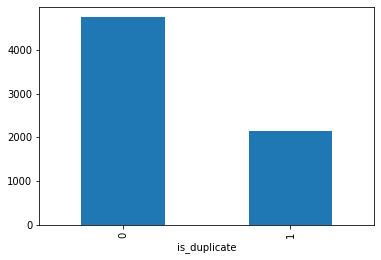

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()
# df['is_duplicate'].value_counts().plot.bar()

In [0]:
dfs = df[0:2500]

In [0]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1','question']
dfq2.columns = ['qid2', 'question']

In [11]:
dfqa = pd.concat((dfq1,dfq2), axis = 0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Transform questions by TF-IDF.

사이킷런의 HashingVectorizer에 대한 공식 문서:   

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html


### HashingVectorizer 장점:


메모리에 어휘 사전을 저장할 필요가 없으므로 매우 적은 메모리를 쓰면서 대규모 데이터 세트를 다룰 수 있다.  


constructor parameter 외에 다른 상태를 보유하지 않기 때문에 pickle 및 un-pickle이 빠르다.  


fit되는 동안에 계산하는 상태가 없기 때문에 streaming(부분 적합) 또는 병렬 파이프 라인에서 사용할 수 있다.


### HashingVectorizer 단점 (in-memory에서  단어의 CountVectorizer를 사용하는 것과 대비해서) 

모델에 어떤 기능이 가장 중요한가를 살펴 볼 때 문제가 될 수 있는 것으로 inverse transform (피쳐 인덱스에서 문자열 피쳐 이름으로)을 계산할 방법이 없다.


충돌하는 경우가 있다 : 서로 다른 토큰을 동일한 기능 인덱스에 매핑 할 수 있다. 그러나 n_features가 충분히 큰 경우인 (예 : 텍스트 분류 문제의 경우 2 ** 18)에는 실제로 문제가 되지 않는다.  


IDF 가중치가 없기 때문에 transformer가 자기 상태를 유지하게 된다.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)

In [13]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 5001 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

t-SNE를 사용하여 TF-IDF 벡터를 3차원 대화형 분산 플롯으로 만드는과정

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', #pca
    random_state=2019,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.032s...
[t-SNE] Computed neighbors for 2500 samples in 2.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.192s
[t-SNE] Iteration 50: error = 79.2391052, gradient norm = 0.1444084 (50 iterations in 9.495s)
[t-SNE] Iteration 100: error = 81.6791382, gradient norm = 0.1180826 (50 iterations in 9.714s)
[t-SNE] Iteration 150: error = 84.0499496, gradient norm = 0.1118991 (50 iterations in 11.610s)
[t-SNE] Iteration 200: error = 85.3423538, gradient norm = 0.1069013 (50 iterations in 11.780s)
[t-SNE] Iteration 250: error = 86.0302734, gradient norm = 0.1152441 (50 iterations in 7.807s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.030273
[t-SNE] Iteration 300: er

In [0]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    ))

In [16]:
data = [trace1]
layout=dict(height=800, width=800, title='test')
fig = dict(data = data, layout=layout)
py.iplot(fig, filename = '3DBubble')

# Feature EDA

In [17]:
df['question1']

0                 1000일 만난 여자친구와 이별
1              10년 연애사 되돌아보니 다 부질없네
2                       10년만나다 헤어지네
3            10월의 마지막밤 . 더 보고싶네 그사람
4                     14년의 기나긴 이야기.
                   ...             
6883                  O형 남자와 썸을 타는데
6884                        SD카드 안돼
6885                 SNS 를 끊어야 하는데.
6886              SNS 시간낭비인데 자꾸 보게됨
6887    sns에서 다른 이성이랑 대화하는걸 보니 화가 나
Name: question1, Length: 6888, dtype: object

In [0]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

# 위 코드들에 대해 부족하지만 이해한대로 적어보겠습니다.
# 우선 1,2번째 줄은 문장의 캐릭터단위의 길이를 새로운 컬럼에 담았습니다.
# 4,5번째 줄은 단어단위의 길이의 수치를 새로운 컬럼에 담았습니다.
# 7~10번줄 띄어쓰기 기준으로 나누고 나눈 word중 겹치는 단어에 대해서 비트와이즈 연산을 통해
# 같으면 1 다르면 0으로 question1,question2의 단어들중 겹치는 단어가 얼만큼 있는지 확인하는 컬럼을 새로 담았습니다.
# 정규화된 어휘들(normalized word)이 오른쪽에 겹쳐 있는데,  유사성이 없는 질문의 경우는 거의 중복이 없다고  해석할 수 있습니다.

In [0]:
df['word_share'] = df.apply(normalized_word_share, axis=1)

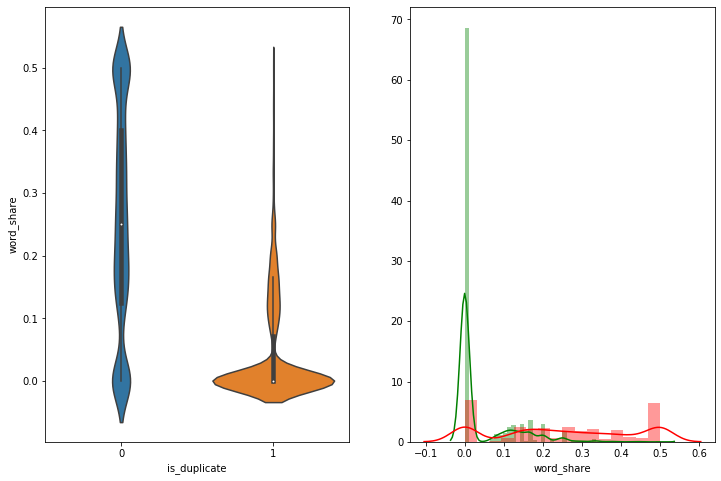

In [20]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000], ax=ax[0])
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], color = 'green', ax=ax[1])
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], color = 'red', ax=ax[1])

# 겹치는 단어의 빈도수에 관한 그래프라고 보여진다.
# is_duplitcate == 1 인 것은 같은 질문이 아니다라는 핸드 레이블링 이다. 즉 겹치는 단어가 거의 없다고 보면된다.
# 그래서 0인부분에 비교적 많이 분포해있다.
# distplot을 통해서도 알 수있듯이 red(is_duplicate == 0 )인 부분은 0~0.5까지 고루분포해 있는 반면에 green(is_duplicate == 1) 인부분은 0이 가장 많다.

In [21]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1,17,8,4,2,0.0
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1,20,20,5,5,0.0
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1,11,13,2,3,0.0
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1,22,6,6,1,0.0
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1,13,16,3,5,0.0


In [0]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size = df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale = 'Portland',
        showscale = True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

In [23]:
layout = go.Layout(
    autosize = True,
    title = 'Scatter plot of character lengths of question one and two',
    hovermode = 'closest',
    xaxis = dict(
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Question 2 length',
        ticklen = 5,
        gridwidth = 2,
        showgrid = False,
        zeroline = False,
        showline = False,
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout = layout)
py.iplot(fig,filename='scatterWords')

# Model starter

+ 지금까지 구축한 기본 기능으로 모델을 러닝할 것이다.
+ 이를 위해 Logisitic 회귀 분석법을 사용할 것이다.
+ CV, ROI 및 PR 곡선을 홀드 아웃 세트에 신속하게 입력하고 제출해 보자.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [25]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1,17,8,4,2,0.0
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1,20,20,5,5,0.0
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1,11,13,2,3,0.0
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1,22,6,6,1,0.0
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1,13,16,3,5,0.0


In [26]:
df.columns[6:].values

array(['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share'],
      dtype=object)

In [27]:
scaler = MinMaxScaler().fit(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2019)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4614, 5), (2274, 5), (4614,), (2274,))

In [28]:
clf = LogisticRegression()

grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty' : ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring = 'neg_log_loss', n_jobs = -1, verbose = 1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

validation 결과를 인쇄:  


어떤 정규식을 썼는가에 관계 없이 강하게 정규화된 모델이 다른 두 모델보다 훨씬 나쁜 negative log loss를 보이고 있다.

In [29]:
for i in range(1, len(cv.cv_results_['params'])+1):
  rank = cv.cv_results_['rank_test_score'][i-1]
  s = cv.cv_results_['mean_test_score'][i-1]
  sd = cv.cv_results_['std_test_score'][i-1]
  params = cv.cv_results_['params'][i-1]
  print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
      rank,
      s,
      sd,
      params
  ))

5. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l1'}
4. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
5. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 0.001, 'penalty': 'l1'}
3. Mean validation neg log loss: -0.606 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.401 (std: 0.010) - {'C': 1.0, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.404 (std: 0.008) - {'C': 1.0, 'penalty': 'l2'}


In [30]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l1'}
[[ 4.79919881  7.30049446 -2.41890006 -3.41062736 -6.16330645]]


# ROC

ROC 커브는 위키 피디아의 설명과 그림 참고

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

네이버 블로그 : https://m.blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221015817276&proxyReferer=https%3A%2F%2Fwww.google.co.uk%2F

C: 1e-06, parameters [[-0.00024113 -0.00018724 -0.00024108 -0.00017732 -0.00074351]] and intercept [-0.00086745]
C: 0.0001, parameters [[-0.02025369 -0.0155896  -0.02052542 -0.01500573 -0.06826281]] and intercept [-0.0735321]
C: 1.0, parameters [[ 3.71240874  4.62120588 -1.49776705 -1.17814034 -5.89932808]] and intercept [-0.7581195]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



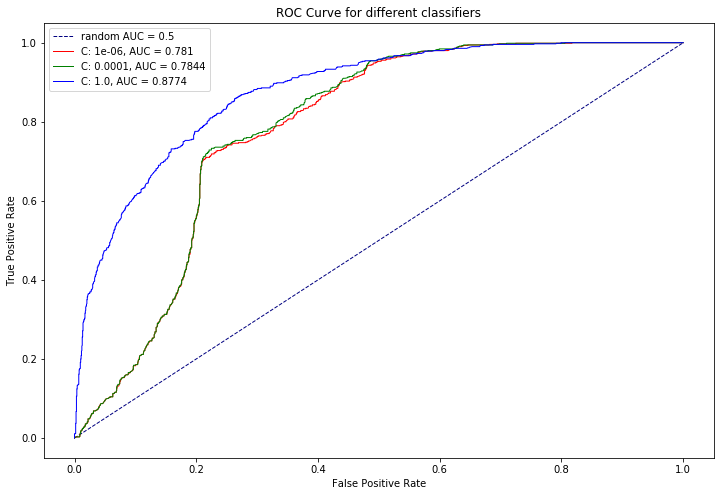

In [40]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

f, ax = plt.subplots(1,1, figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
  clf = LogisticRegression(C = C)
  clf.fit(X_train, y_train)
  print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
  fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=lw, color = colors[idx])
  labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

# Precision-Recall Curve

negatives와 positives 샘플이 꽤 잘 분리되고 있음을 알 수 있다.

Text(0, 0.5, 'Precision')

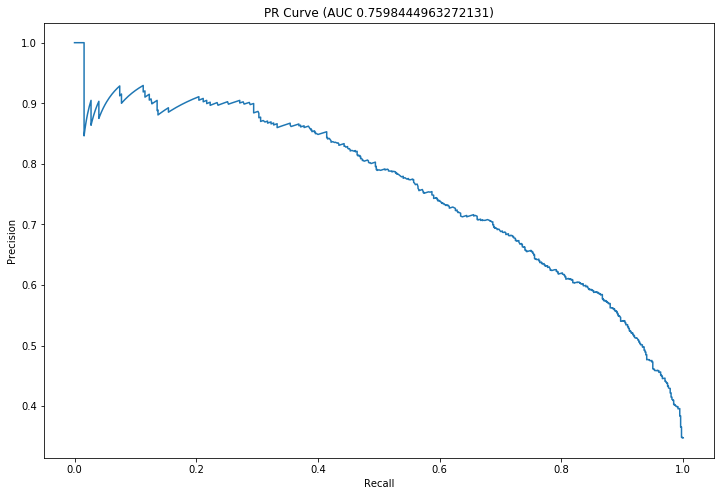

In [42]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re,pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

# Prepare submission

테스트 데이터를 읽어 들인 후 트레이닝 데이터에 사용한 것과 동일한 변환 적용
features를 다시 스케일링

In [52]:
dftest = pd.read_csv("/content/drive/My Drive/colab/질문과 답변/DATA/kor_Pair_test.csv").fillna(" ")

dftest.drop(['Unnamed: 4'],axis = 1, inplace=True)
dftest['q1len'] = dftest['question1'].str.len()
dftest['q2len'] = dftest['question2'].str.len()

dftest['q1_n_words'] = dftest['question1'].apply(lambda row: len(row.split(" ")))
dftest['q2_n_words'] = dftest['question2'].apply(lambda row: len(row.split(" ")))

dftest['word_share'] = dftest.apply(normalized_word_share, axis=1)

dftest.head()

,test_id,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,11,18,3,4,0.000
1,2,2년 가량의 연애,2년 만났어,0,9,6,3,2,0.200
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,11,15,3,5,0.125
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,14,17,3,4,0.000
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,19,21,3,5,0.000


전체 훈련 세트에서 최상의 하이퍼 파라미터를 찾아서 cross-validation에서 발견된 최선의 추정량으로 재훈련

In [53]:
retrained = cv.best_estimator_.fit(X, y)

X_submission = scaler.transform(dftest[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]

submission = pd.DataFrame({'test_id': dftest['test_id'], 'is_duplicate': y_submission})
submission.head()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



,test_id,is_duplicate
0,1,0.765130
1,2,0.066939
2,3,0.272889
3,4,0.798183
4,5,0.902064


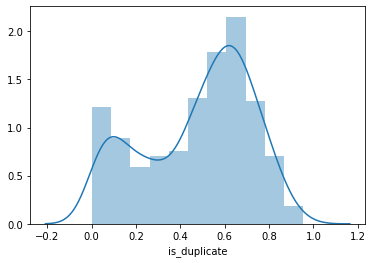

In [54]:
sns.distplot(submission.is_duplicate[0:2000])

In [0]:
submission.to_csv("submission.csv", index=False)